In [1]:
import pandas as pd
from analysis import *
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import binom_test

import matplotlib.pyplot as plt
import numpy as np

In [2]:
surge_annotations = data.surge_evaluation.annotation_dataframe()
surge_annotations_comparative = data.surge_evaluation.comparative_annotation_dataframe()

surge_annotations

0  \
bot            category        label        item                               
rerank_blender likert dialogue emotional    (109,13)_rerank_blender        4   
                               consistent   (109,13)_rerank_blender        4   
                               grammatical  (109,13)_rerank_blender        4   
                               informative  (109,13)_rerank_blender        4   
                               proactive    (109,13)_rerank_blender        4   
...                                                                       ..   
               behavior        follow up    ((438,26)_rerank_blender, 14)  0   
                               topic switch ((438,26)_rerank_blender, 14)  0   
                               ignore       ((438,26)_rerank_blender, 14)  0   
                               irrelevant   ((438,26)_rerank_blender, 14)  0   
                               antisocial   ((438,26)_rerank_blender, 14)  0   

                                                                             1  \
bot            category        label        item                                 
rerank_blender likert dialogue emotional    (109,13)_rerank_blender        4.0   
                               consistent   (109,13)_rerank_blender        4.0   
                               grammatical  (109,13)_rerank_blender        3.0   
                               informative  (109,13)_rerank_blender        4.0   
                               proactive    (109,13)_rerank_blender        3.0   
...                                                                        ...   
               behavior        follow up    ((438,26)_rerank_blender, 14)  NaN   
                               topic switch ((438,26)_rerank_blender, 14)  NaN   
                               ignore       ((438,26)_rerank_blender, 14)  NaN   
                               irrelevant   ((438,26)_rerank_blender, 14)  NaN   
                               antisocial   ((438,26)_rerank_blender, 14)  NaN   

                                                                            2  
bot            category        label        item                               
rerank_blender likert dialogue emotional    (109,13)_rerank_blender       NaN  
                               consistent   (109,13)_rerank_blender       NaN  
                               grammatical  (109,13)_rerank_blender       NaN  
                               informative  (109,13)_rerank_blender       NaN  
                               proactive    (109,13)_rerank_blender       NaN  
...                                                                        ..  
               behavior        follow up    ((438,26)_rerank_blender, 14) NaN  
                               topic switch ((438,26)_rerank_blender, 14) NaN  
                               ignore       ((438,26)_rerank_blender, 14) NaN  
                               irrelevant   ((438,26)_rerank_blender, 14) NaN  
                               antisocial   ((438,26)_rerank_blender, 14) NaN  

[151664 rows x 3 columns]

# 8 Comprehensive Analysis

### Metric Sensitivity

In [3]:
from itertools import combinations
from scipy.stats import ttest_ind

def p_vals(df: pd.DataFrame, test='t'):
    """
    :param df: (bot, data point) x 1 -> score
    :param test: statistical test function (t for t test, p for prop test, s for sign test)
    :return: p values of test on each bot pair (pd.Series)
    """
    bots = set(df.index.get_level_values(0))
    bot_pairs = list(combinations(bots, 2))
    result = {}
    for ba, bb in bot_pairs:
        a = df.xs(ba).to_numpy().squeeze()
        b = df.xs(bb).to_numpy().squeeze()
        if test == 't':
            t, p = ttest_ind(a, b, equal_var=False)
        elif test == 'p':
            z, p = proportions_ztest(count=[
                sum(a), sum(b)
            ], nobs=[
                len(a), len(b)
            ])
        elif test == 's':
            # sign test
            a = a[a==1]
            b = b[b==1]
            p = binom_test(sum(a), sum(a)+sum(b), p=0.5)
        else:
            raise ValueError('invalid arg for param "test"')
        result[(ba, bb)] = p
    result_series = pd.Series(result.values(), result)
    return result_series

@to_file
def t_test_p_values_comparing_bots(annotations):
    annotations = get_singly_annotated(annotations)
    prop_annotations = annotations.xs(
        category.behavior, level=sym.category, drop_level=False
    )
    comp_annotations = annotations.xs(
        category.comparative, level=sym.category, drop_level=False
    )
    mean_annotations = annotations.drop(
        index=category.behavior, level=sym.category
    ).drop(
        index=category.comparative, level=sym.category
    )
    mean_ps = mean_annotations.groupby(
        [sym.category, sym.label]
    ).apply(p_vals)
    prop_ps = prop_annotations.groupby(
        [sym.category, sym.label]
    ).apply(lambda x: p_vals(x, test='p'))
    comp_ps = comp_annotations.groupby(
        [sym.category, sym.label]
    ).apply(lambda x: p_vals(x, test='s'))
    result = pd.concat([prop_ps, mean_ps, comp_ps], axis=0)
    return result

t_test_p_values_comparing_bots(surge_annotations, load='results/t_test_p_values_comparing_bots')

bart_fid_rag_bcb                 \
                                                     emora rerank_blender   
category        label                                                       
behavior        antisocial                    5.596572e-01   1.991940e-02   
                commonsense contradiction     1.640990e-13   1.459336e-02   
                correct fact                  3.113948e-61   1.086676e-19   
                empathetic                    8.622290e-07   1.058880e-08   
                follow up                     2.727890e-38   1.868149e-31   
                ignore                        4.292817e-01   2.234086e-03   
                incorrect fact                6.050642e-54   5.948390e-02   
                irrelevant                    1.638236e-03   1.104154e-06   
                lack of empathy               7.397871e-01   4.425358e-07   
                life info                     5.142244e-05   2.430471e-01   
                partner contradiction         2.793986e-01   4.540203e-01   
                preference info               9.496529e-16   1.628903e-05   
                redundant                     5.492393e-01   8.772313e-02   
                self contradiction            1.761748e-37   7.290264e-15   
                topic switch                  1.579645e-32   4.171605e-23   
                uninterpretable               1.467421e-04   5.253064e-02   
likert dialogue consistent                    3.601692e-06   3.824478e-04   
                emotional                     5.424323e-01   5.048344e-02   
                engaging                      6.880876e-04   7.142167e-05   
                grammatical                   1.322858e-01   1.836517e-02   
                informative                   2.810761e-02   1.673435e-01   
                proactive                     1.613968e-13   1.176406e-09   
                quality                       6.930443e-05   1.610292e-02   
                relevant                      6.858062e-01   8.961838e-01   
likert turn     consistent                    5.699031e-05   3.664685e-02   
                emotional                     2.936840e-01   4.526714e-06   
                engaging                      2.151452e-08   2.807161e-04   
                grammatical                   5.628584e-18   1.621666e-16   
                informative                   1.155927e-46   8.598820e-02   
                proactive                     9.808471e-79   9.617509e-56   
                quality                       1.364643e-04   6.095800e-01   
                relevant                      5.570150e-02   7.936682e-04   
comparative     consistent                    2.108641e-02   3.533280e-01   
                emotional                     1.092954e-01   7.254953e-02   
                engaging                      1.133444e-01   7.206215e-03   
                grammatical                   6.487912e-01   8.284233e-01   
                informative                   2.414317e-01   5.916839e-01   
                proactive                     5.243547e-04   9.264045e-05   
                quality                       2.276262e-01   3.099335e-01   
                relevant                      7.561911e-02   3.048852e-01   

                                                                 emora  \
                                            blender2_3B rerank_blender   
category        label                                                    
behavior        antisocial                 1.600519e-01   6.091482e-03   
                commonsense contradiction  2.098813e-04   6.962009e-07   
                correct fact               1.428960e-16   4.782540e-15   
                empathetic                 1.792820e-07   4.105380e-01   
                follow up                  6.371086e-01   2.082878e-01   
                ignore                     6.748022e-02   1.230902e-04   
                incorrect fact             5.718731e-47   8.8770

### Predictive Validity

In [4]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.regression.linear_model import OLS as LinearModel
from statsmodels.tools.tools import add_constant

def dialogue_metrics(ev):
    df: pd.DataFrame = ev.annotation_dataframe()
    df = get_singly_annotated(df, seed=123)
    reindexed = df.reset_index()
    items = reindexed[sym.item]
    dialogues = [e[0] if isinstance(e, tuple) else e for e in items]
    reindexed['dialogue'] = dialogues
    reindexed.set_index(
        [sym.bot, sym.category, sym.label, 'dialogue', sym.item],
        inplace=True, verify_integrity=True
    )
    ld = reindexed.xs(category.likert_dialogue, level=sym.category)
    ld = ld.droplevel(sym.bot).droplevel(sym.item)
    ld.columns = ['score']
    ldq = ld.xs(scale.quality, level=sym.label)
    ldq.columns = ['quality']

    lt = reindexed.xs(category.likert_turn, level=sym.category)
    lt = lt.groupby([sym.label, 'dialogue']).mean()
    lt.columns = ['score']
    ltq = lt.xs(scale.quality, level=sym.label)
    ltq.columns = ['quality']

    be = reindexed.xs(category.behavior, level=sym.category)
    be = be.groupby([sym.label, 'dialogue']).mean()
    be.columns = ['score']

    ds = pd.concat(
        [lt, be, ld],
        keys=[category.likert_turn, category.behavior, category.likert_dialogue],
        names=[sym.category, sym.label, 'dialogue']
    )
    likert_dialogue_quality_features = ds.join(ldq, on='dialogue')
    likert_turn_quality_features = ds.join(ltq, on='dialogue')
    return likert_dialogue_quality_features, likert_turn_quality_features


def regressions(df, quality_column_name=None, model='linear'):
    """
    :param df: dialogue x (*features, quality) -> value
    :return: *(coef, low, high), mcfadden r^2
    """
    if not quality_column_name:
        quality_column_name = df.columns[-1]
    qualities = df[quality_column_name]
    features = [f for f in df.columns if f != quality_column_name]
    if model == 'ordinal':
        model = OrderedModel(qualities, df[features], distr='logit')
        results = model.fit()
        coefs = {f: results.params[f] for f in features}
        prsqrd = results.prsquared
        result = {stat.mcfad_r2: prsqrd, stat.p_of_llr_test: results.llr_pvalue}
    elif model == 'linear':
        x = add_constant(df[features])
        y = qualities
        model = LinearModel(y, x)
        results = model.fit()
        coefs = {f: results.params[f] for f in features}
        rsquared = results.rsquared
        result = {**coefs, stat.r2: rsquared, stat.p_of_f_test: results.f_pvalue}
    else:
        raise ValueError('Param "model" must be one of {"linear", "ordinal"}')
    return pd.Series(result.values(), result)

In [5]:
@to_file
def dialogue_quality_regressions(ev):
    ldq, ltq = dialogue_metrics(ev)
    ldq_groups = ldq.groupby(
        [sym.category, sym.label]
    )
    ltq_groups = ltq.groupby(
        [sym.category, sym.label]
    )
    names = ['Predicted', 'Metric']
    linear_result = ldq_groups.apply(lambda x: regressions(x, model='linear'))
    linear_result.columns = pd.MultiIndex.from_arrays(
        [['Likert Dialogue Quality']*3,
        ['LR Coefficient', 'LR R-Squared', stat.p_of_f_test]],
        names=names
    )
    ordinal_result = ldq_groups.apply(lambda x: regressions(x, model='ordinal'))
    ordinal_result.columns = pd.MultiIndex.from_arrays(
        [['Likert Dialogue Quality']*2,
        ['OR Pseudo R-Squared', stat.p_of_llr_test]],
        names=names
    )
    linear_turn_result = ltq_groups.apply(regressions)
    linear_turn_result.columns = pd.MultiIndex.from_arrays(
        [['Likert Turn Quality']*3,
        ['LR Coefficient', 'LR R-Squared', stat.p_of_f_test]],
        names=names
    )
    result = pd.concat((linear_turn_result, linear_result, ordinal_result), axis=1)
    return result.round(5)

regs = dialogue_quality_regressions(
    data.surge_evaluation,
    load='results/dialogue_quality_regressions'
)
regs

Predicted                                 Likert Turn Quality               \
Metric                                         LR Coefficient LR R-Squared   
category        label                                                        
likert turn     consistent                            0.22018      0.04654   
                emotional                             0.16635      0.02928   
                engaging                              0.16493      0.04114   
                grammatical                           0.29904      0.06781   
                informative                           0.01924      0.00040   
                proactive                             0.21331      0.06253   
                quality                               1.00000      1.00000   
                relevant                              0.25511      0.09226   
behavior        antisocial                           -3.60729      0.00827   
                commonsense contradiction            -1.19415      0.06063   
                correct fact                         -0.37007      0.01075   
                empathetic                            0.53305      0.03006   
                follow up                             0.51605      0.03255   
                ignore                               -1.71880      0.07233   
                incorrect fact                       -0.90583      0.03955   
                irrelevant                           -1.21588      0.05546   
                lack of empathy                      -1.03156      0.03894   
                life info                             0.21801      0.00280   
                partner contradiction                -1.43733      0.03773   
                preference info                       0.35770      0.01165   
                redundant                            -0.42178      0.00264   
                self contradiction                   -1.19834      0.02215   
                topic switch                         -0.64819      0.01557   
                uninterpretable                      -2.07462      0.00883   
likert dialogue consistent                            0.03822      0.00604   
                emotional                             0.09712      0.02544   
                engaging                              0.08389      0.01732   
                grammatical                           0.03235      0.00221   
                informative                           0.01647      0.00057   
                proactive                             0.05898      0.01004   
                quality                               0.10592      0.02412   
                relevant                              0.12210      0.03822   

Predicted                                                    \
Metric                                    P value of F-test   
category        label                                         
likert turn     consistent                          0.00001   
                emotional                           0.00059   
                engaging                            0.00004   
                grammatical                         0.00000   
                informative                         0.68836   
                proactive                           0.00000   
                quality                             0.00000   
                relevant                            0.00000   
behavior        antisocial                          0.06928   
                commonsense contradiction           0.00000   
                correct fact                        0.03816   
                empathetic                          0.00050   
                follow up                           0.00029   
                ignore                              0.00000   
                incorrect fact                      0.00006   
                irrelevant                          0.00000   
                lack of empathy                     0.00007   
         

In [6]:
to_plot_regs = regs[[("Likert Dialogue Quality", "LR R-Squared"), ("Likert Dialogue Quality", "P value of F-test")]]
to_plot_regs = to_plot_regs.drop(("likert dialogue", "quality"))
to_plot_regs = to_plot_regs.reset_index()
to_plot_regs

Predicted         category                      label Likert Dialogue Quality  \
Metric                                                           LR R-Squared   
0              likert turn                 consistent                 0.02760   
1              likert turn                  emotional                 0.02434   
2              likert turn                   engaging                 0.02657   
3              likert turn                grammatical                 0.00002   
4              likert turn                informative                 0.00141   
5              likert turn                  proactive                 0.03107   
6              likert turn                    quality                 0.02412   
7              likert turn                   relevant                 0.03124   
8                 behavior                 antisocial                 0.00000   
9                 behavior  commonsense contradiction                 0.08446   
10                behavior               correct fact                 0.00025   
11                behavior                 empathetic                 0.04034   
12                behavior                  follow up                 0.00611   
13                behavior                     ignore                 0.04410   
14                behavior             incorrect fact                 0.01083   
15                behavior                 irrelevant                 0.04846   
16                behavior            lack of empathy                 0.05641   
17                behavior                  life info                 0.00485   
18                behavior      partner contradiction                 0.09382   
19                behavior            preference info                 0.00269   
20                behavior                  redundant                 0.04880   
21                behavior         self contradiction                 0.02381   
22                behavior               topic switch                 0.00043   
23                behavior            uninterpretable                 0.01044   
24         likert dialogue                 consistent                 0.28328   
25         likert dialogue                  emotional                 0.26276   
26         likert dialogue                   engaging                 0.39031   
27         likert dialogue                grammatical                 0.07875   
28         likert dialogue                informative                 0.20974   
29         likert dialogue                  proactive                 0.29764   
30         likert dialogue                   relevant                 0.31291   

Predicted                    
Metric    P value of F-test  
0                   0.00085  
1                   0.00175  
2                   0.00107  
3                   0.93777  
4                   0.45444  
5                   0.00040  
6                   0.00184  
7                   0.00038  
8                   0.99747  
9                   0.00000  
10                  0.75402  
11                  0.00005  
12                  0.11850  
13                  0.00002  
14                  0.03750  
15                  0.00001  
16                  0.00000  
17                  0.16446  
18                  0.00000  
19                  0.30064  
20                  0.00001  
21                  0.00197  
22                  0.67809  
23                  0.04108  
24                  0.00000  
25                  0.00000  
26                  0.00000  
27                  0.00000  
28                  0.00000  
29                  0.00000  
30                  0.00000

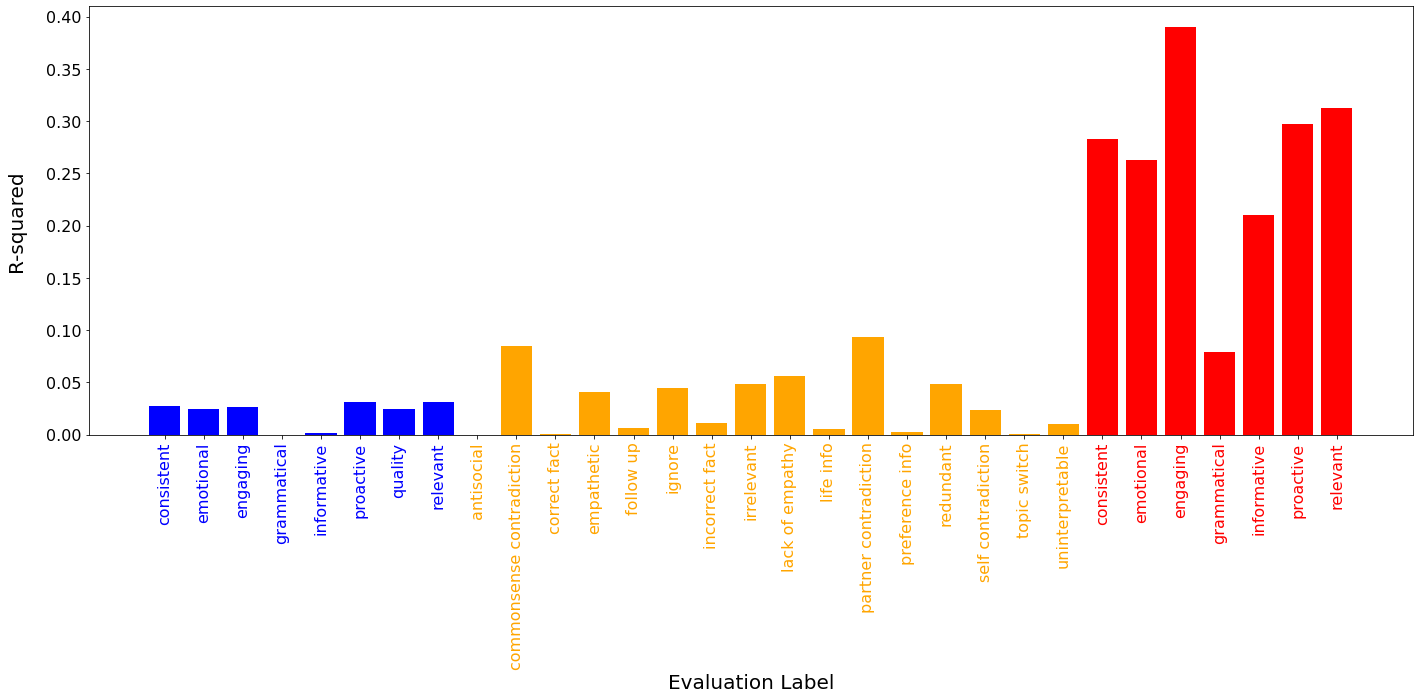

In [17]:
# Build the plot
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()

def plot_by_category(ax, df, category, color, xaxis_start):
    extracted = df[df["category"] == category]
    xaxis_end = xaxis_start + len(extracted)
    ax.bar(np.arange(xaxis_start, xaxis_end),
                extracted[("Likert Dialogue Quality", "LR R-Squared")],
                color=color)
    return xaxis_end

likert_turn_color = "blue"
likert_dialogue_color = "red"
comparative_color = "green"
behavior_color = "orange"

behavior_start = plot_by_category(ax, to_plot_regs, "likert turn", likert_turn_color, 0)
likert_dialogue_start = plot_by_category(ax, to_plot_regs, "behavior", behavior_color, behavior_start)
misc_start = plot_by_category(ax, to_plot_regs, "likert dialogue", likert_dialogue_color, likert_dialogue_start)

category_range = {behavior_start: likert_turn_color, likert_dialogue_start: behavior_color, misc_start: likert_dialogue_color}
xaxis_colors = {}
prev_idx = 0
for idx, color in category_range.items():
    for i in range(prev_idx, idx):
        xaxis_colors[i] = color
    prev_idx = idx

ax.set_ylabel("R-squared", labelpad=20)
xpos = np.arange(len(to_plot_regs))
ax.set_xlabel("Evaluation Label")
ax.set_xticks(xpos)
ax.set_xticklabels(to_plot_regs["label"], rotation=90)
for tickloc, ticklabel in zip(plt.gca().get_xticks(), plt.gca().get_xticklabels()):
    ticklabel.set_color(xaxis_colors[tickloc])

# Save the figure and show
plt.tight_layout()
plt.show()

In [8]:
def drop_column_level_duplication(df: pd.DataFrame, columns, levels=None):
    if levels is None:
        levels = list(range(len(columns)))
    level_columns = df.xs(columns, axis=1, level=levels)
    unique = level_columns.iloc[:,0].to_frame()
    unique.columns = [columns]
    dropped = df.drop(columns=columns, level=levels)
    result = pd.concat([dropped, unique], axis=1)
    return result

def multivariate_regression(df: pd.DataFrame, model='linear'):
    def apply_regressions(df: pd.DataFrame):
        unstacked = df.unstack([sym.category, sym.label])
        unstacked = drop_column_level_duplication(unstacked, 'quality', 0)
        results = regressions(unstacked, quality_column_name='quality', model=model)
        return results
    result = apply_regressions(df)
    result.index = [
        (idx[1] if isinstance(idx, tuple) else idx)
        for idx in result.index.values
    ]
    return result.round(5)

@to_file
def incremental_regression(df: pd.DataFrame, categories, model='linear', exclude_quality=True):
    r2_name = stat.r2 if model=='linear' else stat.mcfad_r2
    p_name = stat.p_of_f_test if model=='linear' else stat.p_of_llr_test
    results = []
    features = []
    feature_pool = {
        x[:2] for x in df.index.values
        if (not (exclude_quality and scale.quality in x))
        and x[0] in categories
    }
    while feature_pool - set(features):
        best = None
        for candidate in feature_pool - set(features):
            candidate_features = features + [candidate]
            row_mask = [
                x[:2] in candidate_features
                and (not (exclude_quality and scale.quality in x))
                and x[0] in categories
                for x in df.index.values
            ]
            candidate_df = df.loc[row_mask, :]
            candidate_results = multivariate_regression(candidate_df, model=model)

            r2 = candidate_results[r2_name].item()
            p = candidate_results[p_name]
            if not best or best[1] < r2:
                best = (candidate, r2, p)
        features.append(best[0])
        results.append(best)
    result = {l: {r2_name: r2, p_name: p} for l, r2, p in results}
    return pd.DataFrame(result.values(), result)

ldq, ltq = dialogue_metrics(data.surge_evaluation)
regs = incremental_regression(
    ldq, (category.likert_turn, category.behavior),
    reload='results/dialogue_incremental_regressions'
)
regs

R-Squared  P value of F-test
behavior    commonsense contradiction    0.06103                0.0
            irrelevant                   0.09182                0.0
            empathetic                   0.11083                0.0
            partner contradiction        0.12129                0.0
            incorrect fact               0.13405                0.0
likert turn relevant                     0.14015                0.0
            grammatical                  0.14605                0.0
behavior    self contradiction           0.15100                0.0
likert turn emotional                    0.15385                0.0
behavior    redundant                    0.15679                0.0
            life info                    0.15966                0.0
            uninterpretable              0.16233                0.0
likert turn engaging                     0.16466                0.0
behavior    follow up                    0.16628                0.0
            topic switch                 0.17063                0.0
            correct fact                 0.17286                0.0
            lack of empathy              0.17413                0.0
            ignore                       0.17542                0.0
likert turn proactive                    0.17655                0.0
behavior    preference info              0.17713                0.0
likert turn informative                  0.17776                0.0
            consistent                   0.17798                0.0
behavior    antisocial                   0.17799                0.0

In [9]:
regs = incremental_regression(
    ldq, (category.behavior,),
    reload='results/behavior_incremental_regressions'
)
regs

R-Squared  P value of F-test
behavior commonsense contradiction    0.06103                0.0
         irrelevant                   0.09182                0.0
         empathetic                   0.11083                0.0
         partner contradiction        0.12129                0.0
         incorrect fact               0.13405                0.0
         self contradiction           0.13874                0.0
         lack of empathy              0.14218                0.0
         redundant                    0.14603                0.0
         correct fact                 0.14834                0.0
         life info                    0.15042                0.0
         uninterpretable              0.15233                0.0
         topic switch                 0.15375                0.0
         follow up                    0.15804                0.0
         preference info              0.15907                0.0
         ignore                       0.15955                0.0
         antisocial                   0.15964                0.0

In [10]:
regs = incremental_regression(
    ldq, (category.likert_turn,),
    reload='results/likert_turn_incremental_regressions'
)
regs

R-Squared  P value of F-test
likert turn relevant       0.03776            0.00009
            proactive      0.05786            0.00001
            consistent     0.06889            0.00000
            emotional      0.07753            0.00000
            engaging       0.08285            0.00000
            informative    0.08508            0.00000
            grammatical    0.08566            0.00001

In [11]:
regs = incremental_regression(
    ldq, (category.likert_dialogue,),
    reload='results/likert_dialogue_incremental_regressions'
)
regs

R-Squared  P value of F-test
likert dialogue engaging       0.38103                0.0
                consistent     0.48673                0.0
                proactive      0.51636                0.0
                relevant       0.54517                0.0
                grammatical    0.56439                0.0
                informative    0.57832                0.0
                emotional      0.58426                0.0

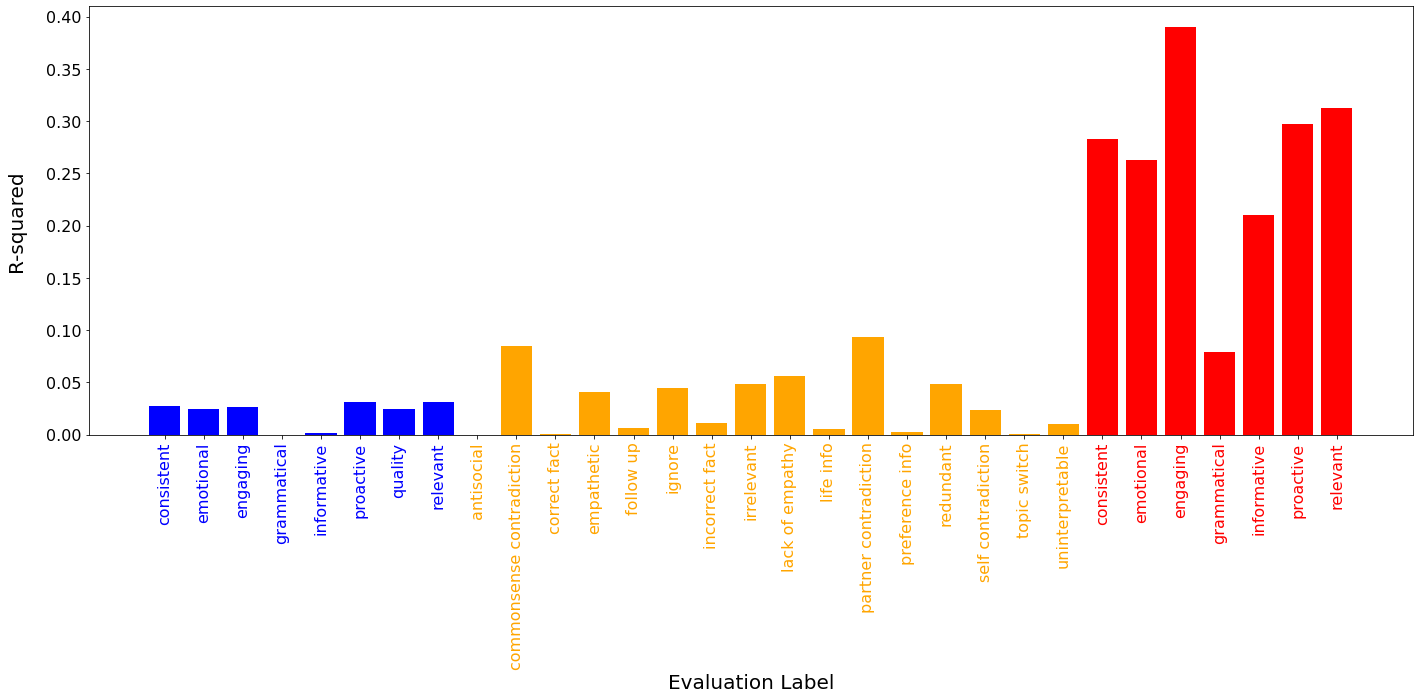

In [12]:
# Build the plot
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()

def plot_by_category(ax, df, category, color, xaxis_start):
    extracted = df[df["category"] == category]
    xaxis_end = xaxis_start + len(extracted)
    ax.bar(np.arange(xaxis_start, xaxis_end),
                extracted[("Likert Dialogue Quality", "LR R-Squared")],
                color=color)
    return xaxis_end

likert_turn_color = "blue"
likert_dialogue_color = "red"
comparative_color = "green"
behavior_color = "orange"

behavior_start = plot_by_category(ax, to_plot_regs, "likert turn", likert_turn_color, 0)
likert_dialogue_start = plot_by_category(ax, to_plot_regs, "behavior", behavior_color, behavior_start)
misc_start = plot_by_category(ax, to_plot_regs, "likert dialogue", likert_dialogue_color, likert_dialogue_start)

category_range = {behavior_start: likert_turn_color, likert_dialogue_start: behavior_color, misc_start: likert_dialogue_color}
xaxis_colors = {}
prev_idx = 0
for idx, color in category_range.items():
    for i in range(prev_idx, idx):
        xaxis_colors[i] = color
    prev_idx = idx

ax.set_ylabel("R-squared", labelpad=20)
xpos = np.arange(len(to_plot_regs))
ax.set_xlabel("Evaluation Label")
ax.set_xticks(xpos)
ax.set_xticklabels(to_plot_regs["label"], rotation=90)
for tickloc, ticklabel in zip(plt.gca().get_xticks(), plt.gca().get_xticklabels()):
    ticklabel.set_color(xaxis_colors[tickloc])

# Save the figure and show
plt.tight_layout()
plt.show()